In [1]:
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import datetime
import matplotlib.dates as mdates
import os
import warnings
import re
from wrf import to_np
import pickle

date_fmt = mdates.DateFormatter('%d-%m'+'\n'+ '%H:%M')
plt.rcParams['figure.facecolor']='white'

os.chdir(os.path.join("/Users/eliotperrin/Desktop/Travail de bachelor/comparaison"))

In [2]:
WProf_datas = "./WProf_data/*ZEN_LV1*"


mdv_plot = None
Ze_plot = None
Rgates_plot = None
Spectral_width_plot = None

x_axis = np.array([])

for element in sorted(glob.glob(WProf_datas)):
    nc = Dataset(element)
    dt = [datetime.datetime.utcfromtimestamp(tt) for tt in nc.variables['Time']]

    if dt[-1] < datetime.datetime(2021, 12, 17, 18):
        continue

    if dt[-1] > datetime.datetime(2021, 12, 19, 12):
        continue 
    
    mdv = nc.variables['Mean-velocity'][:]
    Ze = 10*np.log10(nc.variables['Ze'][:])
    SNR = 10*np.log10(nc.variables['Ze'][:]/nc.variables['Linear-sensitivity-vert'][:])
    mdv[SNR<26]=np.nan # This seems to be an appropriate threshold to filter out noise
    
    Rgates = nc.variables['Rgate'][:]/1000
    Spectral_width = nc.variables['Spectral-width'][:]
    
    # test du snr
    #Ze.mask = SNR<-24
    Ze[SNR<30]=np.nan
    Spectral_width[SNR<26]= np.nan
    
    if mdv_plot is None:
        mdv_plot = mdv 
    else:
        mdv_plot = np.concatenate((mdv_plot, mdv), axis=0)  
    
    if Ze_plot is None:
        Ze_plot = Ze  
    else:
        Ze_plot = np.concatenate((Ze_plot, Ze), axis=0)  
    
    if Rgates_plot is None:
        Rgates_plot = Rgates  
    else:
        Rgates_plot = np.concatenate((Rgates_plot, Rgates), axis=0) 

    if Spectral_width_plot is None:
        Spectral_width_plot = Spectral_width
    else:
        Spectral_width_plot = np.concatenate((Spectral_width_plot, Spectral_width), axis=0) 
    
    
    x_axis = np.append(x_axis, dt)

In [3]:
#suppress warnings
warnings.filterwarnings('ignore')


###################################
# Model Outputs - Demott       #
###################################

# find all files starting with "Output" and ending in ".nc" but not containing "_"
pattern = re.compile(r'^Output[^_]*\.nc$')

# get a list of all files in the current directory
files = os.listdir('/Users/eliotperrin/Desktop/Travail de bachelor/CR-SIM Demott')

# filter the files using the regular expression
filelist = [file for file in files if pattern.match(file)]

nfiles = len(filelist)

# Initialize empty numpy array
REFL = np.empty((nfiles, 97))
DOPPLER = np.empty((nfiles, 97))
SP_WIDTH = np.empty((nfiles, 97))
print(nfiles)

# current = os.getcwd()
os.chdir(os.path.join("/Users/eliotperrin/Desktop/Travail de bachelor/CR-SIM Demott"))

# Loop over files and append data
#for i, fn in enumerate(filelist):
for i, fn in enumerate(sorted(filelist, key=lambda x: int(re.findall(r'\d+', x)[0]))):
    
    ds = Dataset(fn)
    
    refl = np.squeeze(np.array(ds.variables['Zhh'][:]))  ##Reflectivity at hh polarization, dBz
    REFL[i] = refl
    
    doppler = np.squeeze(np.array(ds.variables['DV'][:]))  ##Radial Doppler velocity, positive upward [m/s]
    DOPPLER[i] = doppler
    
    sp_width = np.squeeze(np.array(ds.variables['SWtot'][:]))  ##Radial Doppler velocity, positive upward [m/s]
    SP_WIDTH[i] = sp_width

# Check shape of array
print(REFL.shape)


REFL[REFL==-999.0] = np.nan; DOPPLER[DOPPLER==-999.0] = np.nan; SP_WIDTH[SP_WIDTH==-999.0] = np.nan


wrf_time = np.arange(np.datetime64('2021-12-17T00:00'), np.datetime64('2021-12-19T12:01'),dtype='datetime64[s]')[::1800]
spin_up = np.where(wrf_time == np.datetime64('2021-12-17T21:00'))[0][0]  #42
end = np.where(wrf_time == np.datetime64('2021-12-19T12:00'))[0][0] + 1  #len(wrf_time)

wrf_time = wrf_time[spin_up:end]
print(wrf_time.shape)



os.chdir('..')
os.chdir(os.path.join("/Users/eliotperrin/Desktop/Travail de bachelor/WRF_outputs_VL"))
### Read the altitude of the WRF model levels
# /!\ change this path

#simu_CONTROL = 'wrfout_Helmos_d03_CONTROL_LONGER_VL_3.nc'
simu_CONTROL = 'wrfout_Helmos_d03_DEMOTT_VL.nc' 
ncCNT = Dataset(simu_CONTROL)

PHB = np.squeeze(ncCNT.variables["PHB"][0,:])
PH = np.squeeze(ncCNT.variables["PH"][0,:])
HGT = np.squeeze(ncCNT.variables["HGT"][0])
ZZASL = (PH+PHB)/9.81
ZZ = (PH+PHB)/9.81-HGT
dz=np.zeros((len(ZZ)-1))        #height difference between consecutive vertical levels
ZZmiddle=np.zeros((len(ZZ)-1))  #height in the middle of each grid box

kk = 0

for jj in range(len(ZZ)-1):
        dz[kk] = (ZZ[kk+1]-ZZ[kk])/2
        ZZmiddle[kk] = dz[kk] + ZZ[kk]
        kk=kk+1

120
(120, 97)
(79,)


In [4]:
### WRF constants
RA=287.15
RD=287.0
CP=1004.5
P1000MB=100000.0
EPS=0.622

presCNT = np.squeeze(ncCNT.variables['P'][:] + ncCNT.variables['PB'][:])

thetCNT = np.squeeze(ncCNT.variables['T'][:] + 300.0)

qvCNT = np.squeeze(ncCNT.variables['QVAPOR'][:])

tkCNT = ((presCNT / P1000MB)**(RD/CP) * thetCNT)

tCNT = tkCNT - 273.15 #Temperature in Celsius degrees
tCNT = tCNT[spin_up:end]

In [5]:

#suppress warnings
warnings.filterwarnings('ignore')


###################################
# Model Outputs - Allsip      #
###################################

# find all files starting with "Output" and ending in ".nc" but not containing "_"
pattern = re.compile(r'^Output[^_]*\.nc$')

# get a list of all files in the current directory
files = os.listdir('/Users/eliotperrin/Desktop/Travail de bachelor/CR-SIM allsip')

# filter the files using the regular expression
filelist = [file for file in files if pattern.match(file)]

nfiles = len(filelist)

# Initialize empty numpy array
REFL_allsip = np.empty((nfiles, 97))
DOPPLER_allsip = np.empty((nfiles, 97))
SP_WIDTH_allsip = np.empty((nfiles, 97))
print(nfiles)

# current = os.getcwd()
os.chdir(os.path.join("/Users/eliotperrin/Desktop/Travail de bachelor/CR-SIM allsip"))

# Loop over files and append data
#for i, fn in enumerate(filelist):
for i, fn in enumerate(sorted(filelist, key=lambda x: int(re.findall(r'\d+', x)[0]))):
    
    ds = Dataset(fn)
    
    refl_allsip = np.squeeze(np.array(ds.variables['Zhh'][:]))  ##Reflectivity at hh polarization, dBz
    REFL_allsip[i] = refl_allsip
    
    doppler_allsip = np.squeeze(np.array(ds.variables['DV'][:]))  ##Radial Doppler velocity, positive upward [m/s]
    DOPPLER_allsip[i] = doppler_allsip
    
    sp_width_allsip = np.squeeze(np.array(ds.variables['SWtot'][:]))  ##Radial Doppler velocity, positive upward [m/s]
    SP_WIDTH_allsip[i] = sp_width_allsip

# Check shape of array
print(REFL_allsip.shape)


REFL_allsip[REFL_allsip==-999.0] = np.nan; DOPPLER_allsip[DOPPLER_allsip==-999.0] = np.nan; SP_WIDTH_allsip[SP_WIDTH_allsip==-999.0] = np.nan

os.chdir('..')
os.chdir(os.path.join("/Users/eliotperrin/Desktop/Travail de bachelor/WRF_outputs_VL"))
### Read the altitude of the WRF model levels
# /!\ change this path

#simu_CONTROL = 'wrfout_Helmos_d03_CONTROL_LONGER_VL_3.nc'
simu_CONTROL = 'wrfout_Helmos_d03_ALLSIP02_VL.nc' 
ncCNT_allsip = Dataset(simu_CONTROL)

PHB_allsip = np.squeeze(ncCNT_allsip.variables["PHB"][0,:])
PH_allsip = np.squeeze(ncCNT_allsip.variables["PH"][0,:])
HGT_allsip = np.squeeze(ncCNT_allsip.variables["HGT"][0])
ZZASL_allsip = (PH_allsip+PHB_allsip)/9.81
ZZ_allsip = (PH_allsip+PHB_allsip)/9.81-HGT_allsip
dz_allsip=np.zeros((len(ZZ_allsip)-1))        #height difference between consecutive vertical levels
ZZmiddle_allsip=np.zeros((len(ZZ_allsip)-1))  #height in the middle of each grid box

kk = 0

for jj in range(len(ZZ_allsip)-1):
        dz_allsip[kk] = (ZZ_allsip[kk+1]-ZZ_allsip[kk])/2
        ZZmiddle_allsip[kk] = dz_allsip[kk] + ZZ_allsip[kk]
        kk=kk+1

120
(120, 97)


['2021-12-17T21:00:00' '2021-12-17T21:30:00' '2021-12-17T22:00:00'
 '2021-12-17T22:30:00' '2021-12-17T23:00:00' '2021-12-17T23:30:00'
 '2021-12-18T00:00:00' '2021-12-18T00:30:00' '2021-12-18T01:00:00'
 '2021-12-18T01:30:00' '2021-12-18T02:00:00' '2021-12-18T02:30:00'
 '2021-12-18T03:00:00' '2021-12-18T03:30:00' '2021-12-18T04:00:00'
 '2021-12-18T04:30:00' '2021-12-18T05:00:00' '2021-12-18T05:30:00'
 '2021-12-18T06:00:00' '2021-12-18T06:30:00' '2021-12-18T07:00:00'
 '2021-12-18T07:30:00' '2021-12-18T08:00:00' '2021-12-18T08:30:00'
 '2021-12-18T09:00:00' '2021-12-18T09:30:00' '2021-12-18T10:00:00'
 '2021-12-18T10:30:00' '2021-12-18T11:00:00' '2021-12-18T11:30:00'
 '2021-12-18T12:00:00' '2021-12-18T12:30:00' '2021-12-18T13:00:00'
 '2021-12-18T13:30:00' '2021-12-18T14:00:00' '2021-12-18T14:30:00'
 '2021-12-18T15:00:00' '2021-12-18T15:30:00' '2021-12-18T16:00:00'
 '2021-12-18T16:30:00' '2021-12-18T17:00:00' '2021-12-18T17:30:00'
 '2021-12-18T18:00:00' '2021-12-18T18:30:00' '2021-12-18T19:00

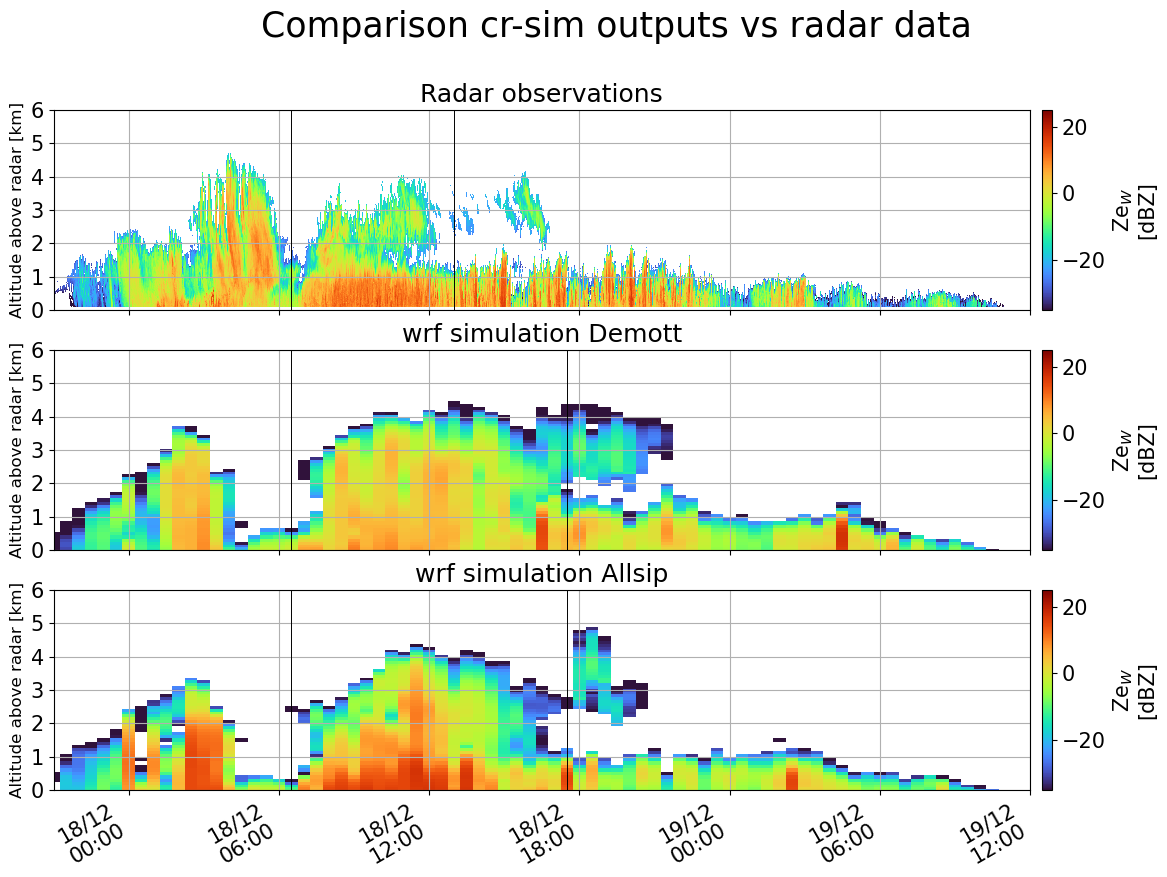

In [6]:
plt.rcParams['font.size']=15
fig,axs = plt.subplots(3,1,figsize=(15,10),sharex=True)
fig.suptitle('Comparison cr-sim outputs vs radar data', fontsize=25)

im0=axs[0].pcolormesh(x_axis,Rgates,Ze_plot.T,vmin=-35,vmax=25,cmap='turbo')

axs[0].set_ylabel('Altitude above radar [km]', fontsize=12)
axs[0].set_title('Radar observations')

axs[0].set_yticks([0,1,2,3,4,5,6])
axs[0].grid()

l1_datas = axs[0].axvline((datetime.datetime(2021, 12, 18, 6, 30)), color = 'k',linewidth=0.7)
l2_datas = axs[0].axvline((datetime.datetime(2021, 12, 18, 13, 00)), color = 'k',linewidth=0.7)

axs[0].set_ylim(0,6)

# Isoterm
#cs = axs[0].contour(wrf_time,ZZmiddle/1000,tCNT.T,levels=np.arange(-50, 0,10), colors='black')
#axs[0].clabel(cs, inline=True,fontsize=10, fmt='%d$^\circ$C')

#axs[0].set_xlim(wrf_time[spin_up],wrf_time[end-1])

im1 = axs[1].pcolormesh(to_np(wrf_time[0:-1]),to_np(ZZ)/1000,REFL[spin_up:end-1].T,vmin=-35,vmax=25,cmap='turbo')
# Quand on plot la réfléctivité on fait spin_up:end-1

axs[1].set_xlim(wrf_time[0], wrf_time[-1])
axs[1].set_title('wrf simulation Demott')

l1_model = axs[1].axvline((datetime.datetime(2021, 12, 18, 6, 30)), color = 'k',linewidth=0.7)
l2_model = axs[1].axvline((datetime.datetime(2021, 12, 18, 17, 30)), color = 'k',linewidth=0.7)


axs[1].set_ylabel('Altitude above radar [km]', fontsize=12)
axs[1].set_ylim(0,6)
axs[1].set_yticks([0,1,2,3,4,5,6])
axs[1].grid()

xfmt = mdates.DateFormatter('%d/%m' +'\n'+ '%H:%M')
xlocator = mdates.MinuteLocator(interval = 360)
axs[1].xaxis.set_major_locator(xlocator)
axs[1].xaxis.set_major_formatter(xfmt)

########################
im2 = axs[2].pcolormesh(to_np(wrf_time[0:-1]),to_np(ZZ_allsip)/1000,REFL_allsip[spin_up:end-1].T,vmin=-35,vmax=25,cmap='turbo')

axs[2].set_xlim(wrf_time[0], wrf_time[-1])
axs[2].set_title('wrf simulation Allsip')

l1_model = axs[2].axvline((datetime.datetime(2021, 12, 18, 6, 30)), color = 'k',linewidth=0.7)
l2_model = axs[2].axvline((datetime.datetime(2021, 12, 18, 17, 30)), color = 'k',linewidth=0.7)

axs[2].set_ylabel('Altitude above radar [km]', fontsize=12)
axs[2].set_ylim(0,6)
axs[2].set_yticks([0,1,2,3,4,5,6])
axs[2].grid()

xfmt = mdates.DateFormatter('%d/%m' +'\n'+ '%H:%M')
xlocator = mdates.MinuteLocator(interval = 360)
axs[2].xaxis.set_major_locator(xlocator)
axs[2].xaxis.set_major_formatter(xfmt)
########################



#cs = axs[1].contour(wrf_time,ZZmiddle/1000, tCNT.T,levels=np.arange(-50, 0,10), colors='black')
#axs[1].clabel(cs, inline=True,fontsize=10, fmt='%d$^\circ$C')


#im2 = axs[1].pcolormesh(to_np(wrf_time[0:-1]),to_np(ZZ_allsip)/1000,REFL_allsip[spin_up:end-1].T,vmin=-35,vmax=25,cmap='turbo')



fig.autofmt_xdate()
plt.colorbar(im0,label=r'Ze$_{W}$'+'\n[dBZ]',pad=.01,ax=axs[0])
plt.colorbar(im1, label=r'Ze$_{W}$'+'\n[dBZ]',pad=.01,ax=axs[1])
plt.colorbar(im2,label=r'Ze$_{W}$'+'\n[dBZ]',pad=.01,ax=axs[2])

print(wrf_time, tCNT )

In [7]:
print(wrf_time.shape, tCNT.shape)

(79,) (79, 96)


In [8]:
with open('variables.pkl', 'wb') as f:
    pickle.dump((wrf_time[spin_up:end], ZZmiddle/1000, (tCNT.T)[:,spin_up:end]), f)

In [9]:
# Coupure pour les données radar, pas encore utilisé pour le moment

cut1 = datetime.datetime(2021, 12, 18, 6, 30)
cut2 = datetime.datetime(2021, 12, 18, 13, 30)

# Découpage du tableau
periode1_datas = x_axis[x_axis < cut1]
periode2_datas = x_axis[(x_axis >= cut1) & (x_axis < cut2)]
periode3_datas = x_axis[x_axis >= cut2]

print(len(periode1_datas), len(periode2_datas), len(periode3_datas))

9683 5422 17427


In [10]:
refl_datas = Ze_plot
refl_model_demott = REFL[spin_up-1:end]
refl_model_allsip = REFL_allsip[spin_up-1:end]

refl_model_demott = refl_model_demott.T
refl_model_allsip = refl_model_allsip.T


print(refl_datas.shape, refl_model_demott.shape, refl_model_allsip.shape)

(32532, 460) (97, 79) (97, 79)


In [11]:
#In this cell, the datas from the wprof are separated in 3 periods

dates = np.array([np.datetime64(d) for d in x_axis])

start1 = np.where(dates <= np.datetime64('2021-12-18T06:30:00'))[0][-1] + 1
end1 = np.where(dates <= np.datetime64('2021-12-18T13:30:00'))[0][-1] + 1
start2 = end1
end2 = np.where(dates <= np.datetime64('2021-12-19T12:00:00'))[0][-1] + 1

data1 = refl_datas[:start1,:]
data2 = refl_datas[start1:end1,:]
data3 = refl_datas[start2:end2,:]

print(data1.shape)
print(data2.shape)
print(data3.shape)
print(Rgates.shape)

data1 = data1.T
data2 = data2.T
data3 = data3.T

median_refl_datas1 = np.nanmedian(data1, axis=1)
percentile1_10 = np.nanpercentile(data1, 10, axis=1)
percentile1_90 = np.nanpercentile(data1, 90, axis=1) 

median_refl_datas2 = np.nanmedian(data2, axis=1)
percentile2_10 = np.nanpercentile(data2, 10, axis=1)
percentile2_90 = np.nanpercentile(data2, 90, axis=1) 

median_refl_datas3 = np.nanmedian(data3, axis=1)
percentile3_10 = np.nanpercentile(data3, 10, axis=1)
percentile3_90 = np.nanpercentile(data3, 90, axis=1) 


(9683, 460)
(5422, 460)
(17427, 460)
(460,)


(97, 37)


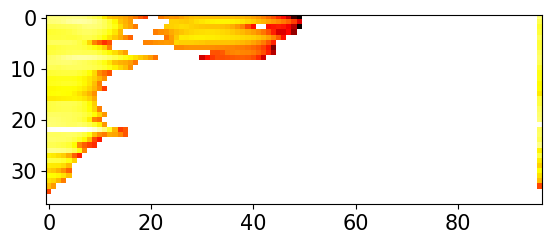

In [12]:
#In this cell, the datas from the model are separated in 3 periods

dates = np.array([np.datetime64(d) for d in wrf_time])

start1 = np.where(dates <= np.datetime64('2021-12-18T06:30:00'))[0][-1] + 1
end1 = np.where(dates <= np.datetime64('2021-12-18T17:30:00'))[0][-1] + 1
start2 = end1
end2 = np.where(dates <= np.datetime64('2021-12-19T12:00:00'))[0][-1] + 1

data1 = refl_model_demott[:, :start1]
data2 = refl_model_demott[:, start1:end1]
data3 = refl_model_demott[:, start2:end2]

print(data3.shape)

data1 = data1.T
data2 = data2.T
data3 = data3.T

median_refl_demott1 = np.nanmedian(data1, axis=0)
median_refl_demott2 = np.nanmedian(data2, axis=0)
median_refl_demott3 = np.nanmedian(data3, axis=0)

plt.imshow(data3, cmap='hot')


(97, 79)
(20, 97)


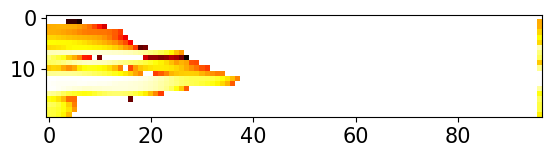

In [13]:
#In this cell, the datas from the model are separated in 3 periods

dates = np.array([np.datetime64(d) for d in wrf_time])

start1 = np.where(dates <= np.datetime64('2021-12-18T06:30:00'))[0][-1] + 1
end1 = np.where(dates <= np.datetime64('2021-12-18T17:30:00'))[0][-1] + 1
start2 = end1
end2 = np.where(dates <= np.datetime64('2021-12-19T12:00:00'))[0][-1] + 1

data1 = refl_model_allsip[:, :start1]
data2 = refl_model_allsip[:, start1:end1]
data3 = refl_model_allsip[:, start2:end2]

print(refl_model_allsip.shape)

data1 = data1.T
data2 = data2.T
data3 = data3.T

median_refl_allsip1 = np.nanmedian(data1, axis=0)

median_refl_allsip2 = np.nanmedian(data2, axis=0)
median_refl_allsip3 = np.nanmedian(data3, axis=0)

plt.imshow(data1, cmap='hot')
print(data1.shape)


(0.0, 4.0)

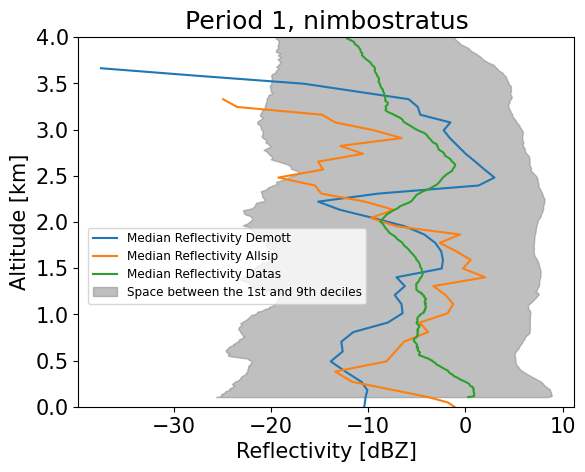

In [39]:
# Plot for the first period

plt.plot(median_refl_demott1, (to_np(ZZ)/1000), label='Median Reflectivity Demott')
plt.plot(median_refl_allsip1, (to_np(ZZ)/1000), label='Median Reflectivity Allsip')
plt.plot(median_refl_datas1, Rgates, label='Median Reflectivity Datas')
plt.fill_betweenx(Rgates, percentile1_10, percentile1_90, color = 'grey', alpha = 0.5, label = 'Space between the 1st and 9th deciles')
plt.title('Period 1, nimbostratus')
plt.ylabel('Altitude [km]')
plt.xlabel('Reflectivity [dBZ]')

plt.legend(loc='upper center', bbox_to_anchor=(0.3, 0.5), fontsize='xx-small')
plt.ylim(0, 4)


(0.0, 4.0)

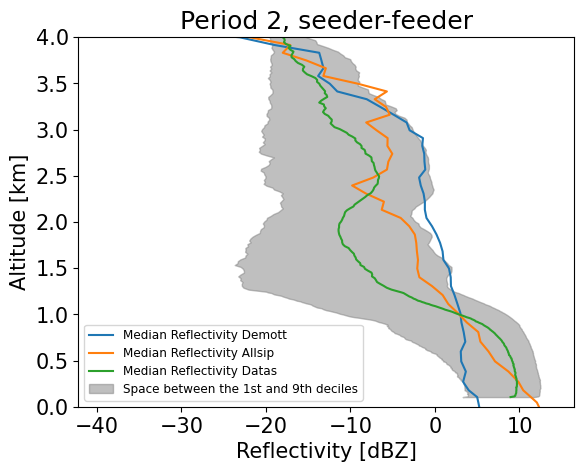

In [40]:
# Plot for the second period

plt.plot(median_refl_demott2, (to_np(ZZ)/1000), label='Median Reflectivity Demott')
plt.plot(median_refl_allsip2, (to_np(ZZ)/1000), label='Median Reflectivity Allsip')
plt.plot(median_refl_datas2, Rgates, label='Median Reflectivity Datas')
plt.fill_betweenx(Rgates, percentile2_10, percentile2_90, color = 'grey', alpha = 0.5, label = 'Space between the 1st and 9th deciles')

plt.title('Period 2, seeder-feeder')
plt.ylabel('Altitude [km]')
plt.xlabel('Reflectivity [dBZ]')

plt.legend(fontsize='xx-small')
plt.ylim(0, 4)

(0.0, 2.0)

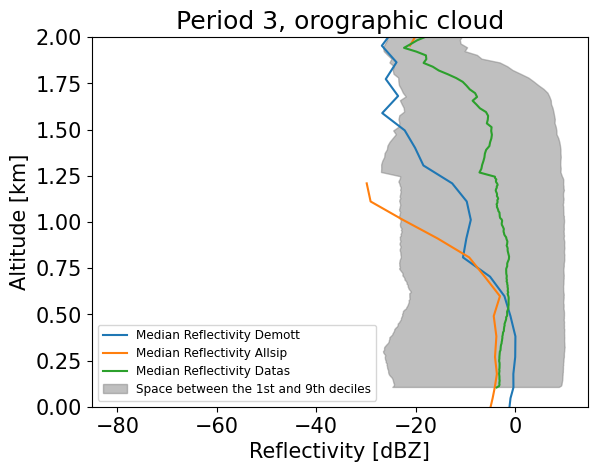

In [41]:
plt.plot(median_refl_demott3, (to_np(ZZ)/1000), label='Median Reflectivity Demott')
plt.plot(median_refl_allsip3, (to_np(ZZ)/1000), label='Median Reflectivity Allsip')
plt.plot(median_refl_datas3, Rgates, label='Median Reflectivity Datas')
plt.fill_betweenx(Rgates, percentile3_10, percentile3_90, color = 'grey', alpha = 0.5, label = 'Space between the 1st and 9th deciles')
plt.title('Period 3, orographic cloud')
plt.ylabel('Altitude [km]')
plt.xlabel('Reflectivity [dBZ]')

plt.legend(fontsize='xx-small')
plt.ylim(0, 2)
